In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import h5py

from vis.visualization import visualize_activation
from vis.utils import utils
from vis.visualization import visualize_cam
from vis.visualization import visualize_saliency, overlay
from keras import activations
from keras import backend as K
from keras.models import load_model

#plt.rcParams['figure.figsize'] = (18, 6)

Using TensorFlow backend.


In [2]:
#Let's load the model and data
model = load_model('resnet50_new.h5')
hf = h5py.File('data_new.h5', 'r')

In [3]:
#training data
x_train = np.array(hf.get('x_train'))
y_train = np.array(hf.get('y_train'))
#validation data
x_validate = np.array(hf.get('x_validate'))
y_validate = np.array(hf.get('y_validate'))
#testing data
x_test = np.array(hf.get('x_test'))
y_test = np.array(hf.get('y_test'))

In [4]:
x_train.shape

(7210, 224, 224, 3)

In [5]:
# Let's get model predictions for the validation set
Y_pred = model.predict(x_validate)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 

In [6]:
Y_pred[0]

array([9.22270920e-06, 2.43427280e-06, 4.70760060e-05, 1.52108705e-05,
       9.99517441e-01, 4.37873359e-06, 4.04158607e-04], dtype=float32)

In [7]:
Y_pred_classes[0]

4

In [8]:
Y_true[0]

4

In [9]:
val_acc = (Y_pred_classes == Y_true)

In [10]:
val_acc[0]

True

In [11]:
np.mean(val_acc) #make sure this matches up to what we saw in the prev notebook

0.8117206982543641

In [12]:
loss, accuracy = model.evaluate(x_validate,
                                            y_validate,
                                            verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

802/802 [==============================] - 157s 195ms/step
Validation: accuracy = 0.811721  ;  loss = 0.847642


In [13]:
from sklearn.metrics import classification_report

lesions = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'mel', 'vasc']
print(classification_report(Y_true, Y_pred_classes, target_names=lesions))

              precision    recall  f1-score   support

       akiec       1.00      0.54      0.70        26
         bcc       0.71      0.61      0.66        41
         bkl       0.52      0.74      0.61        88
          df       0.57      0.44      0.50         9
          nv       0.95      0.88      0.91       537
         mel       0.56      0.72      0.63        89
        vasc       0.82      0.75      0.78        12

   micro avg       0.81      0.81      0.81       802
   macro avg       0.73      0.67      0.68       802
weighted avg       0.84      0.81      0.82       802



In [14]:
# Let's find some examples where the model went wrong
misclass = np.where(val_acc == False)[0]

In [15]:
Y_pred_classes[misclass[0]]

6

In [16]:
Y_true[misclass[0]]

4

In [17]:
Y_pred_classes[misclass]

array([6, 5, 5, 5, 2, 5, 2, 4, 5, 2, 2, 4, 2, 2, 1, 5, 5, 2, 2, 2, 3, 5,
       2, 4, 5, 4, 2, 2, 2, 5, 2, 5, 2, 5, 5, 4, 2, 4, 2, 4, 2, 2, 5, 2,
       2, 5, 2, 4, 1, 2, 2, 1, 4, 5, 2, 2, 5, 2, 1, 5, 2, 2, 2, 5, 5, 2,
       2, 5, 2, 3, 2, 2, 4, 4, 5, 2, 2, 2, 2, 2, 2, 1, 5, 5, 5, 2, 5, 2,
       2, 2, 5, 5, 4, 2, 4, 5, 4, 4, 5, 6, 2, 3, 2, 5, 1, 5, 5, 5, 4, 5,
       4, 2, 5, 4, 5, 2, 5, 1, 2, 2, 4, 2, 2, 5, 5, 1, 5, 2, 4, 2, 4, 5,
       4, 5, 2, 5, 5, 1, 2, 4, 5, 5, 5, 1, 2, 5, 5, 4, 5, 2, 2])

In [27]:
unique, counts = np.unique(Y_pred_classes[misclass], return_counts=True)
dict(zip(unique, counts))

{1: 10, 2: 61, 3: 3, 4: 24, 5: 51, 6: 2}

In [19]:
Y_pred[misclass[0]] #here you see positive weights for the correct class (5) but 4 is just higher

array([1.9972273e-07, 4.1374358e-05, 3.5778160e-04, 3.8600776e-02,
       1.6141690e-01, 1.4031862e-03, 7.9817981e-01], dtype=float32)

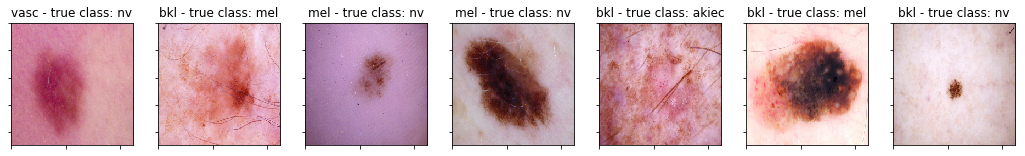

In [20]:
#let's look at some examples
plt.rcParams['figure.figsize'] = (18, 10)
plt.figure()

f, ax = plt.subplots(1,7)
s = ' - true class: '
for i in range(7):
    ax[i].xaxis.set_ticklabels([])
    ax[i].yaxis.set_ticklabels([])
    
    x = x_validate[misclass[i]]
    toplot = (x - np.min(x))/np.ptp(x)
    
    ax[i].imshow(toplot)
    text = {lesions[Y_pred_classes[misclass[i]]], #prediction
                        lesions[Y_true[misclass[i]]]} #true
    ax[i].title.set_text(s.join(text)) #true


In [28]:
loss, accuracy = model.evaluate(x_test,
                                y_test,
                                verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

2003/2003 [==============================] - 382s 191ms/step
Test: accuracy = 0.841238  ;  loss = 0.681060


In [29]:
# Let's get model predictions for the test set
Y_pred_test = model.predict(x_test)
Y_pred_classes_test = np.argmax(Y_pred_test,axis = 1) 

# Convert test observations to one hot vectors
Y_true_test = np.argmax(y_test,axis = 1) 

In [30]:
print(classification_report(Y_true_test, Y_pred_classes_test, target_names=lesions))

              precision    recall  f1-score   support

       akiec       0.80      0.37      0.51        65
         bcc       0.82      0.72      0.77       103
         bkl       0.60      0.79      0.69       220
          df       0.75      0.65      0.70        23
          nv       0.96      0.90      0.93      1341
         mel       0.57      0.75      0.65       223
        vasc       0.95      0.68      0.79        28

   micro avg       0.84      0.84      0.84      2003
   macro avg       0.78      0.70      0.72      2003
weighted avg       0.86      0.84      0.85      2003

